In [2]:
from pathlib import Path
import pandas as pd

import re
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from textblob import TextBlob
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krzyzinskim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krzyzinskim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
PATH_METADATA = Path('../corpora/UN General Debate Corpus/Speakers_by_session.xlsx')
PATH_SESSION = Path('../corpora/UN General Debate Corpus/TXT/Session 77 - 2022')

In [4]:
def get_session_txts():
    txt_paths = PATH_SESSION.glob('*.txt')
    txts = {}
    for txt_path in txt_paths:
        txt_id = txt_path.name.split('.')[0]
        with open(txt_path) as f:
            txt = f.readlines()
        txt_flat = ''.join(txt).replace('\n', ' ')
        txts[txt_id] = txt_flat
    return txts
   
def get_metadata():
    names = ['Year', 'Session',	'ISO Code', 'Country', 'Name of Person Speaking', 'Post']
    metadata = pd.read_excel(PATH_METADATA, usecols = names)
    return metadata

def get_session_csv():
    metadata = get_metadata()
    txts = get_session_txts()
    metadata['Text'] = None
    for txt_id, txt in txts.items():
        iso_code, session, year = txt_id.split('_')
        metadata.loc[
            (metadata['ISO Code'] == iso_code) & 
            (metadata.Session == int(session)) & 
            (metadata.Year == int(year)), 'Text'] = txt
    metadata = metadata[metadata.Text.notna()]
    metadata['text_clean'] = metadata.Text.str.lower()
    metadata['text_clean'] = metadata.text_clean.apply(clean_text)
    metadata['token'] = metadata.text_clean.apply(word_tokenize)
    return metadata

def remove_stopwords(s):
    return [e for e in s if e not in stopwords.words('english')] 

def clean_text(s):    
    # remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # keep only regular chars
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    return cleaned.strip()

In [6]:
data = get_session_csv()
data.head()

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Text,text_clean,token
0,2022,77,BRA,Brazil,Jair Bolsonaro,President,"I would like to greet the Secretary-General, w...","i would like to greet the secretary general, w...","[i, would, like, to, greet, the, secretary, ge..."
1,2022,77,SEN,Senegal,Macky Sail,President,"On behalf of the African Union, I would like t...","on behalf of the african union, i would like t...","[on, behalf, of, the, african, union, ,, i, wo..."
2,2022,77,CHL,Chile,Gabriel Boric Font,President,It is an honour for me to be here among Member...,it is an honour for me to be here among member...,"[it, is, an, honour, for, me, to, be, here, am..."
3,2022,77,JOR,Jordan,Abdullah II ibn Al Hussein,King,"We meet today, in this General Assembly, as th...","we meet today, in this general assembly, as th...","[we, meet, today, ,, in, this, general, assemb..."
4,2022,77,COL,Colombia,Gustavo Petro Urrego,President,I come from one of the three most beautiful co...,i come from one of the three most beautiful co...,"[i, come, from, one, of, the, three, most, bea..."


# Most frequent words

In [69]:
full_text = np.concatenate(data.token)
full_text_no_sw = np.array([e for e in full_text if e not in stopwords.words('english')])
full_text_no_sw = np.delete(full_text_no_sw, np.where(full_text_no_sw == ','))
unique_words, counts = np.unique(full_text_no_sw, return_counts = True)

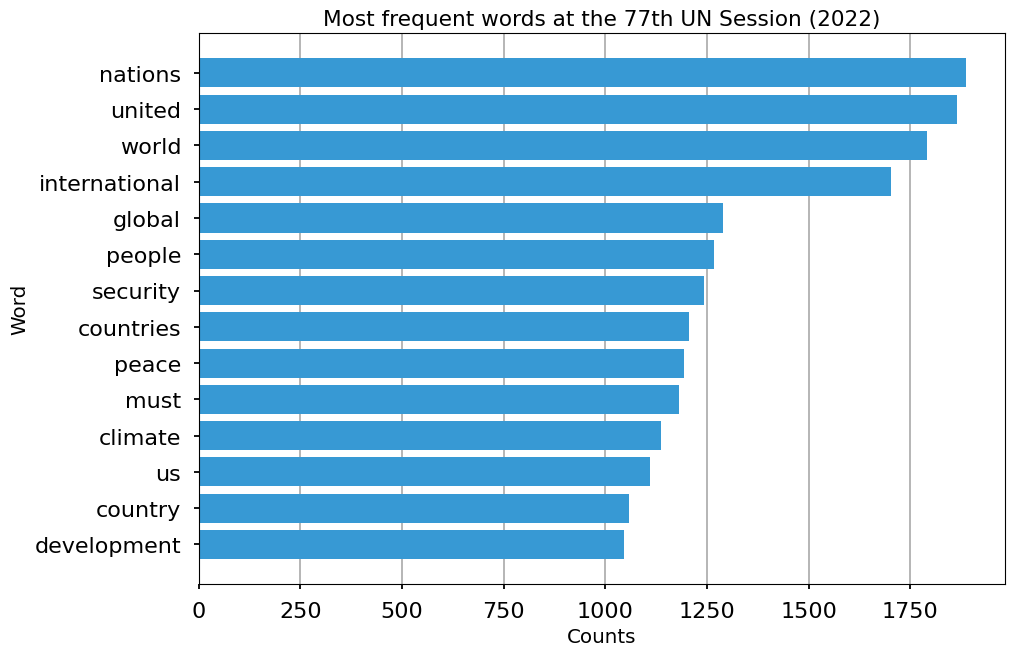

In [70]:
plt.style.use("seaborn-v0_8-talk")
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.axisbelow"] = True
n_top = 15
idx_sorted = np.argsort(counts)
top_words = unique_words[idx_sorted][:-n_top:-1]
top_counts = counts[idx_sorted][:-n_top:-1]
plt.barh(top_words[::-1], top_counts[::-1], color="#3799D4")
plt.title("Most frequent words at the 77th UN Session (2022)")
plt.xlabel("Counts")
plt.ylabel("Word")
plt.grid(axis="x")
plt.savefig("proposal_figures/most_frequent_words.png", dpi=300, bbox_inches="tight")

# Sentiment analysis

In [54]:
data['polarity'] = data.text_clean.apply(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data.text_clean.apply(lambda x: TextBlob(x).sentiment.subjectivity)

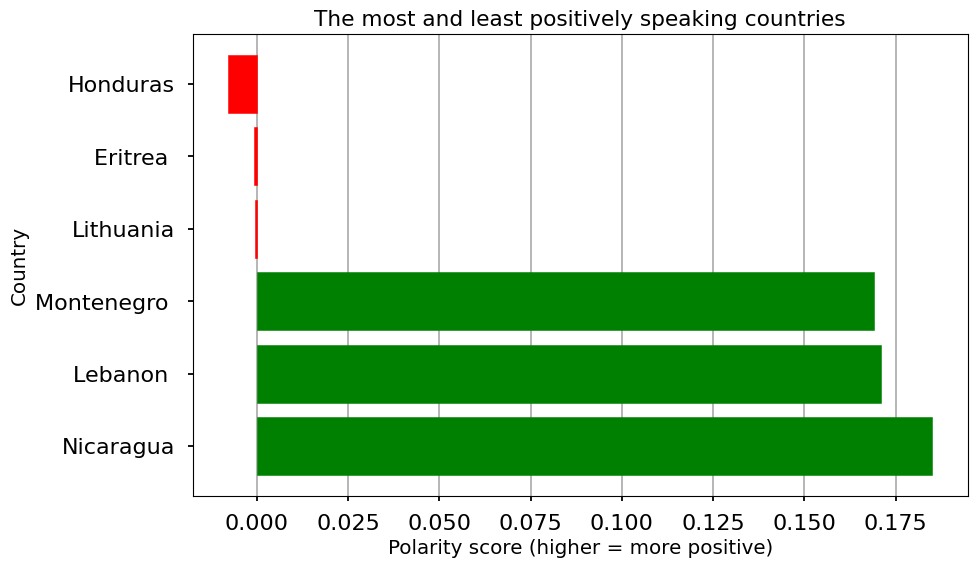

In [63]:
n_top = 3
most_positive = data.sort_values("polarity", ascending=False)[:n_top][["Country", "polarity"]]
least_positive = data.sort_values("polarity", ascending=False)[-n_top:][["Country", "polarity"]]

plt.figure(figsize=(10, 6))
plot = plt.barh(
    np.concatenate([most_positive.Country, least_positive.Country]),
    np.concatenate([most_positive.polarity, least_positive.polarity]),
)

[bar.set_color("g") for bar in plot[:-n_top]]
[bar.set_color("r") for bar in plot[n_top:]]
plt.title("The most and least positively speaking countries")
plt.ylabel("Country")
plt.xlabel("Polarity score (higher = more positive)")
plt.grid(axis="x")
plt.savefig("proposal_figures/polarity.png", dpi=300, bbox_inches="tight")

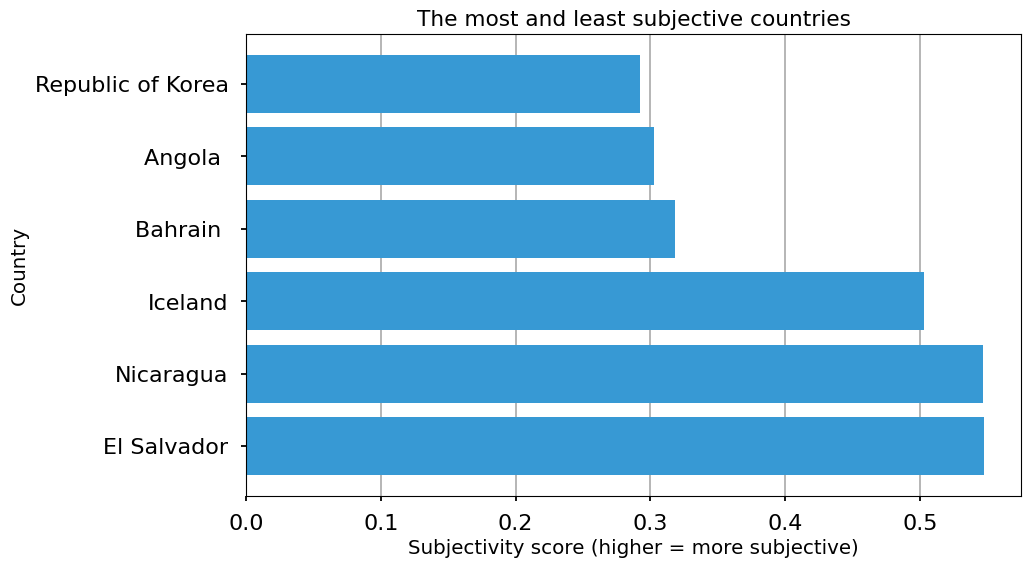

In [68]:
n_top = 3
most_positive = data.sort_values("subjectivity", ascending=False)[:n_top][["Country", "subjectivity"]]
least_positive = data.sort_values("subjectivity", ascending=False)[-n_top:][["Country", "subjectivity"]]

plt.figure(figsize=(10, 6))
plot = plt.barh(
    np.concatenate([most_positive.Country, least_positive.Country]),
    np.concatenate([most_positive.subjectivity, least_positive.subjectivity]),
    color="#3799D4",
)

plt.title("The most and least subjective countries")
plt.ylabel("Country")
plt.xlabel("Subjectivity score (higher = more subjective)")
plt.grid(axis="x")
plt.savefig("proposal_figures/subjectivity.png", dpi=300, bbox_inches="tight")

# Word cloud

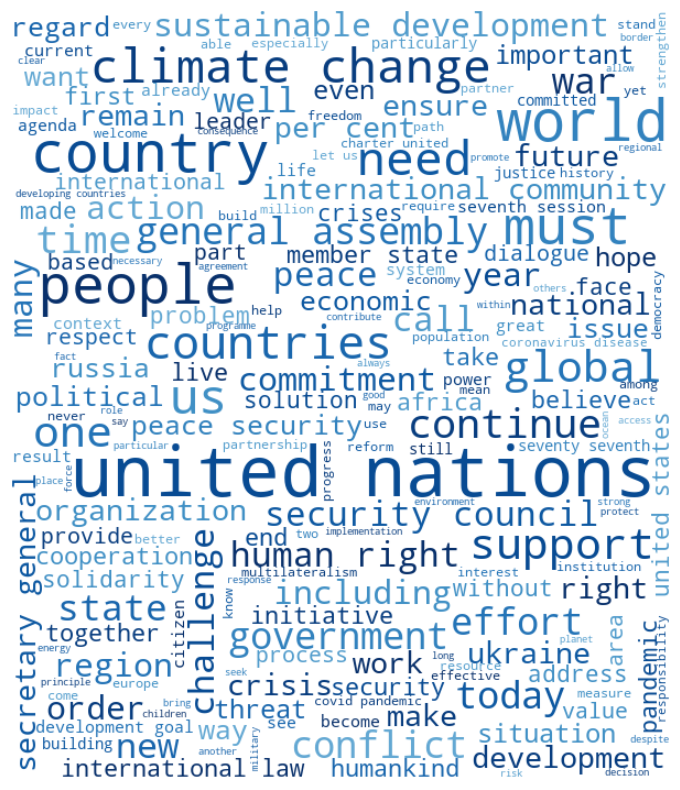

In [36]:
from wordcloud import WordCloud
from matplotlib import cm, colors

cmap = cm.Blues(np.linspace(0, 1, 20))
cmap = colors.ListedColormap(cmap[10:, :-1])

wc = WordCloud(width=600, height=700, background_color="white", colormap=cmap)
wc_text = " ".join(full_text_no_sw)
wc_gen = wc.generate(wc_text)
plt.figure(figsize=(12, 10))
plt.imshow(wc_gen, interpolation="bilinear")
plt.axis("off")
plt.savefig("proposal_figures/wordcloud.png", dpi=300, bbox_inches="tight")

# Summary

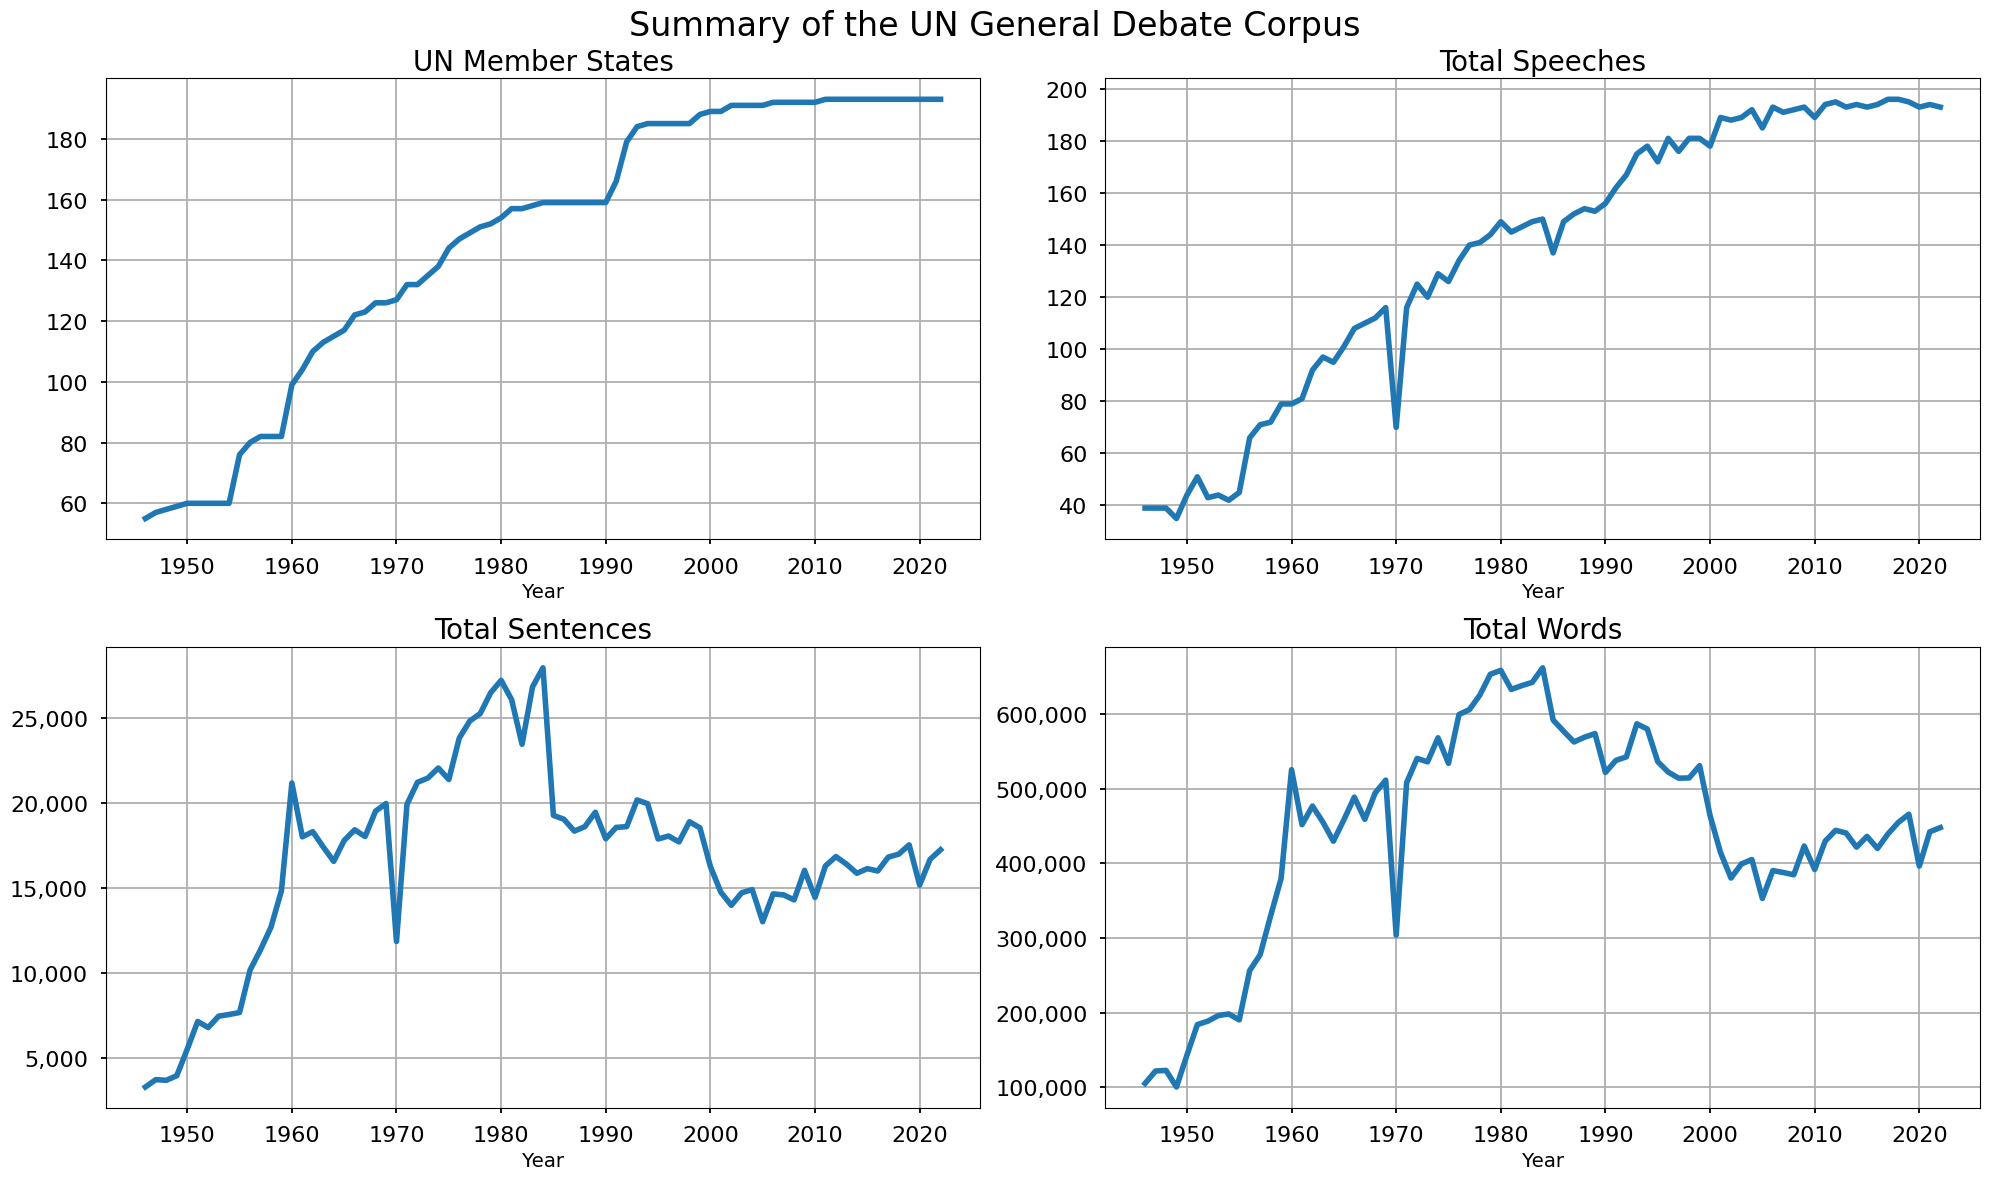

In [53]:
from matplotlib import ticker

path_table = "un_table.txt"
table = pd.read_table(path_table)

x_label = table.columns[0]
y_labels = table.columns[1:]

fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

for idx, ax in enumerate(axs):
    y_label = y_labels[idx]
    ax.plot(table[x_label], table[y_label], linewidth=4)
    ax.set_title(y_label, size=20)
    ax.set_xlabel(x_label)
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
    ax.grid()
plt.suptitle("Summary of the UN General Debate Corpus", size=24)
plt.tight_layout()
plt.savefig("proposal_figures/summary.png", dpi=300, bbox_inches="tight")